# Restaurant: Crowded or Not classifier using Resnet-34

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [7]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !cp ~/kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json

In [21]:
!kaggle datasets download -d dhruvt93/restaurant-crowded-or-not -f restaurant_images.tar.gz -p data/restaurant-images

 98%|████████████████████████████████████████▎| 189M/192M [00:01<00:00, 162MB/s]
100%|█████████████████████████████████████████| 192M/192M [00:01<00:00, 182MB/s]


In [26]:
!tar -xzf data/restaurant-images/restaurant_images.tar.gz -C data/restaurant-images

In [28]:
!ls data/restaurant-images/data

crowded  empty


In [29]:
DATA_PATH = 'data/restaurant-images/data'

In [33]:
BATCH_SIZE = 32

In [40]:
classes = ['crowded','empty']

In [30]:
path = Path(DATA_PATH)

In [31]:
path.ls()

[PosixPath('data/restaurant-images/data/crowded'),
 PosixPath('data/restaurant-images/data/empty')]

One buggy image in dataset. Need to run cleaner for now.

In [41]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

crowded


cannot identify image file '/home/nbuser/courses/fast-ai/course-v3/nbs/dl1/data/restaurant-images/data/crowded/00000239.jpg'
empty


In [32]:
get_transforms??

Signature: get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: float = None) -> Collection[fastai.vision.image.Transform]
Source:   
def get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                   p_lighting:float=0.75, xtra_tfms:float=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    res = [rand_crop()]
    if do_flip:    res.append(dihedral_affine() if flip_vert else flip_affine(p=0.5))
    if max_warp:   res.append(symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine))
    if max_rotate: res.append(rotate(degrees=(-max_rotate,max_rotate), p=p_affine))
    if max_zoom>1: res.append(rand_zoom(scal

In [34]:
imagenet_stats??

Type:        tuple
String form: ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
Length:      2
Docstring:  
Built-in immutable sequence.

If no argument is given, the constructor returns an empty tuple.
If iterable is specified the tuple is initialized from iterable's items.

If the argument is a tuple, the return value is the same object.


In [42]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.15,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=BATCH_SIZE).normalize(imagenet_stats)

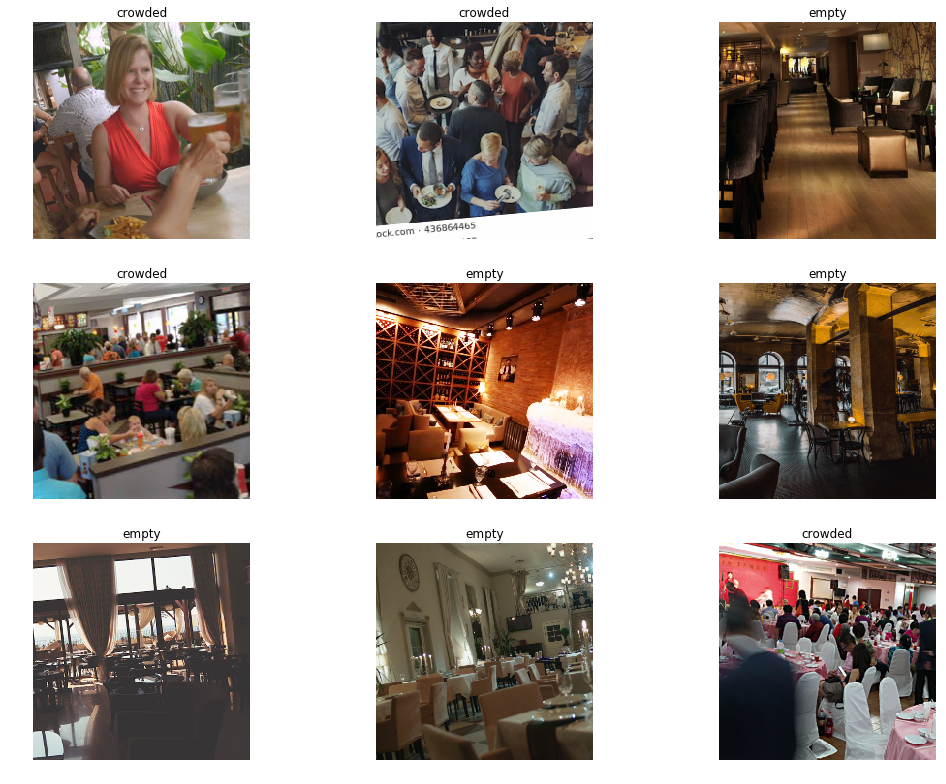

In [47]:
data.show_batch(rows=3, figsize=(15,11))

In [37]:
print(data.classes)
len(data.classes),data.c

['crowded', 'empty']


(2, 2)

## Training: resnet34

In [43]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [44]:
learn.fit_one_cycle(4)

Total time: 01:00
epoch  train_loss  valid_loss  error_rate
1      0.476517    0.101566    0.045455    (00:16)
2      0.316234    0.098530    0.034091    (00:13)
3      0.247839    0.097567    0.022727    (00:14)
4      0.201583    0.098507    0.022727    (00:14)



In [45]:
learn.save('stage-1')

## Results

In [46]:
interp = ClassificationInterpretation.from_learner(learn)

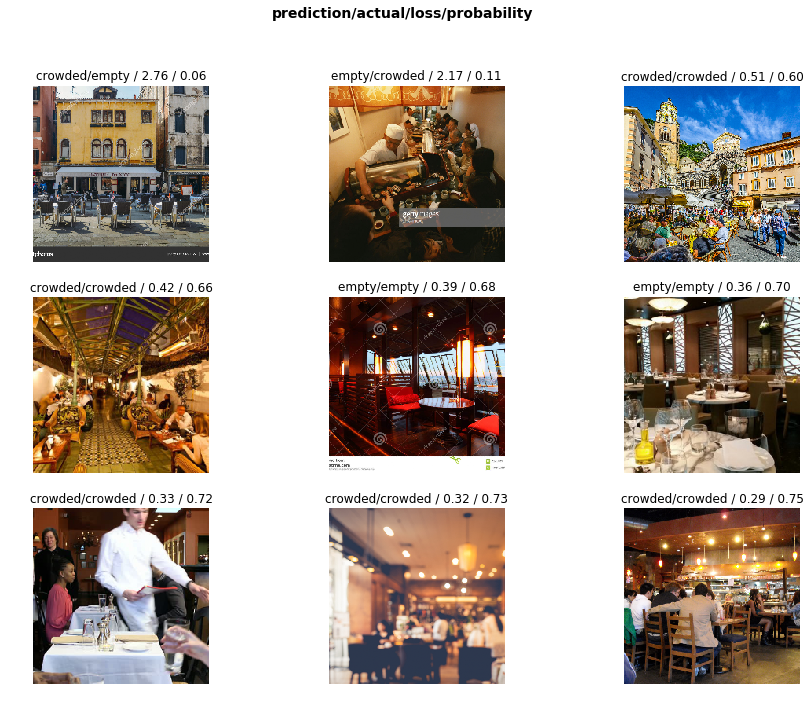

In [48]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

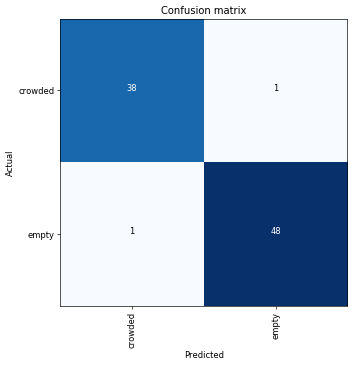

In [52]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [56]:
interp.most_confused(min_val=2)

[]

## Unfreezing, fine-tuning, and learning rates

In [57]:
learn.unfreeze()

In [58]:
learn.fit_one_cycle(1)

Total time: 00:15
epoch  train_loss  valid_loss  error_rate
1      0.361671    0.341714    0.102273    (00:15)



Getting worse. Bad `lr`.

In [74]:
learn.load('stage-1')

In [75]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


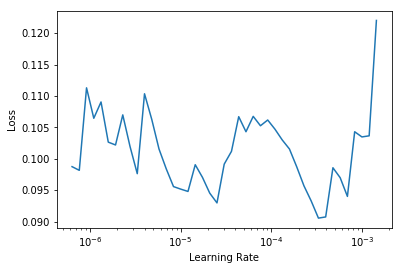

In [76]:
learn.recorder.plot()

Trying with range `(1e-4,4e-4)`.

In [77]:
learn.unfreeze()
learn.fit_one_cycle(6, max_lr=slice(1e-4,4e-4))

Total time: 01:32
epoch  train_loss  valid_loss  error_rate
1      0.151147    0.090329    0.022727    (00:15)
2      0.102417    0.030858    0.011364    (00:15)
3      0.139781    0.129561    0.034091    (00:16)
4      0.114910    0.036051    0.022727    (00:15)
5      0.090610    0.014022    0.000000    (00:14)
6      0.068706    0.014758    0.000000    (00:14)



In [78]:
learn.save('stage-2-unfreezed-6-epochs')

In [79]:
!wget https://c7.alamy.com/comp/KBCFYF/richmond-virginia-shockoe-bottom-neighborhood-shops-lulus-restaurant-KBCFYF.jpg -O test_img1.jpg

--2018-11-01 10:35:46--  https://c7.alamy.com/comp/KBCFYF/richmond-virginia-shockoe-bottom-neighborhood-shops-lulus-restaurant-KBCFYF.jpg
Resolving c7.alamy.com (c7.alamy.com)... 13.33.155.254, 13.33.155.76, 13.33.155.6, ...
Connecting to c7.alamy.com (c7.alamy.com)|13.33.155.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘test_img1.jpg’

test_img1.jpg           [  <=>               ] 224.56K   708KB/s    in 0.3s    

2018-11-01 10:35:46 (708 KB/s) - ‘test_img1.jpg’ saved [229945]



In [92]:
img = open_image('test_img1.jpg')

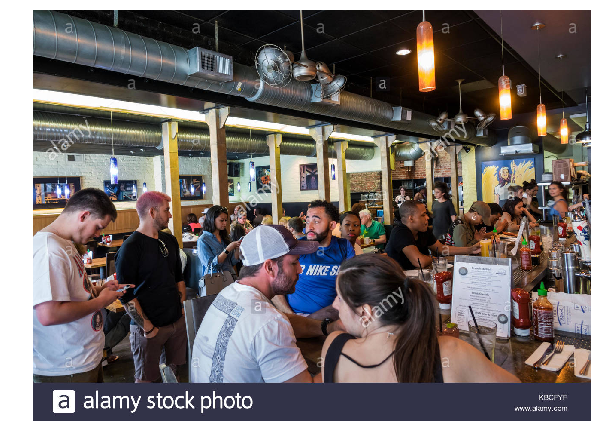

In [96]:
show_image(img,figsize=(10,8));

In [85]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'crowded'

In [86]:
!wget https://media-cdn.tripadvisor.com/media/photo-s/05/e9/61/dc/james-pub-cancun.jpg -O test_img2.jpg

--2018-11-01 10:38:25--  https://media-cdn.tripadvisor.com/media/photo-s/05/e9/61/dc/james-pub-cancun.jpg
Resolving media-cdn.tripadvisor.com (media-cdn.tripadvisor.com)... 93.184.215.11
Connecting to media-cdn.tripadvisor.com (media-cdn.tripadvisor.com)|93.184.215.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64936 (63K) [image/jpeg]
Saving to: ‘test_img2.jpg’

test_img2.jpg       100%[===================>]  63.41K  --.-KB/s    in 0.01s   

2018-11-01 10:38:25 (6.19 MB/s) - ‘test_img2.jpg’ saved [64936/64936]



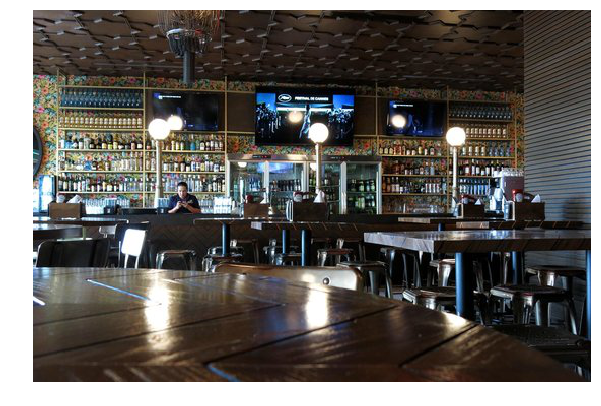

In [97]:
img2 = open_image('test_img2.jpg')
show_image(img2,figsize=(10,8));

In [88]:
pred_class,pred_idx,outputs = learn.predict(img2)
pred_class

'empty'

## sweet.

TODO:
- Upload clean dataset to Kaggle.
- Add doc to nb